In [29]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

from sklearn.neighbors import KNeighborsClassifier

from graspy.simulations import sbm
from graspy.embed import MultipleASE, OmnibusEmbed
from graspy.plot import heatmap, pairplot

from rerf.rerfClassifier import rerfClassifier

from tqdm import tqdm_notebook as tqdm

%matplotlib inline

### Generating Samples

We will generate 10 graphs each from four different population of stochastic block models (SBMs), which represent four classes. Each graph has 256 vertices, and the four classes have the following block matrices:

$$B^{(k)} = 0.25(\mathbb{1}\mathbb{1}^T) + \alpha C^{(k)}$$ where

$$
C^{(1)} = \begin{bmatrix} 
.1 & 0 \\
0 & .1
\end{bmatrix}
\quad
C^{(2)} = -\begin{bmatrix} 
.1 & 0 \\
0 & .1
\end{bmatrix}
\quad
C^{(3)} = \begin{bmatrix} 
.1 & 0 \\
0 & 0
\end{bmatrix}
\quad
C^{(4)} = \begin{bmatrix} 
0 & 0 \\
0 & .1
\end{bmatrix}
\quad
$$

In [2]:
def generate_data(n=10, alpha=0.1, seed=None):
    np.random.seed(seed)
    
    C1 = [[.1, 0],
          [0, .1]]
    C2 = [[-.1, 0],
          [0, -.1]]
    C3 = [[.1, 0],
          [0, 0]]
    C4 = [[0, 0],
          [0, .1]]
    
    ones = np.ones((2, 2)) * .25
    
    out = []
    for C in [C1, C2, C3, C4]:
        for _ in range(n):
            p = ones + alpha * np.array(C)
            out.append(sbm(n=[128, 128], p=p))
            
    labels = np.repeat([0, 1, 2, 3], n)
        
    return np.array(out), labels

Text(0.5, 0.98, 'alpha = 1.5')

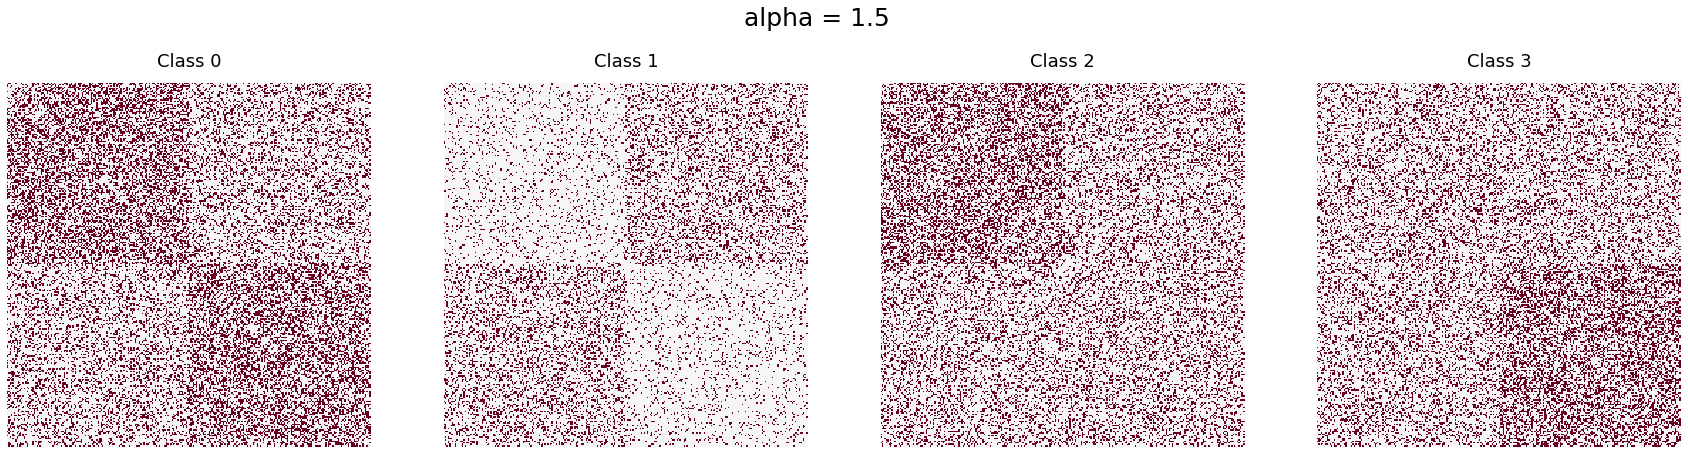

In [3]:
graphs, labels = generate_data(alpha=1.5)

fig, ax = plt.subplots(ncols=4, figsize=(30, 7.5))

for i, j in enumerate(range(0, 40, 10)):
    heatmap(graphs[j], ax=ax[i], cbar=False, title=f"Class {labels[j]}")

fig.suptitle("alpha = 1.5", fontsize=25)

In [6]:
    idx = np.triu_indices(256, k=1)


In [8]:
def run_srerf(XTRAIN, YTRAIN, XTEST, YTEST):
    XTRAIN = XTRAIN.copy().reshape(40, -1)
    XTEST = XTEST.copy().reshape(40, -1)

    cls = rerfClassifier(
        projection_matrix="S-RerF",
        max_features=40,
        n_jobs=90,
        n_estimators=500,
        oob_score=False,
        random_state=None,
        image_height=256,
        image_width=256,
        patch_height_max=16,
        patch_height_min=1,
        patch_width_max=16,
        patch_width_min=1
    )
    
    cls.fit(XTRAIN, YTRAIN)
    
    preds = np.array(cls.predict(XTEST))
    error = np.mean(preds != YTEST)
    
    return error


def run_rerf(XTRAIN, YTRAIN, XTEST, YTEST):
    idx = np.triu_indices(256, k=1)
    
    XTRAIN = np.array([x[idx] for x in XTRAIN])
    XTEST = np.array([x[idx] for x in XTEST])

    cls = rerfClassifier(
        projection_matrix="RerF",
        n_jobs=90,
        n_estimators=500,
        oob_score=False,
        random_state=None,
    )
    
    cls.fit(XTRAIN, YTRAIN)
    
    preds = np.array(cls.predict(XTEST))
    error = np.mean(preds != YTEST)
    
    return error

def run_mase(XTRAIN, YTRAIN, XTEST, YTEST):
    X = np.vstack([XTRAIN, XTEST])
    
    mase = MultipleASE(n_components=2, scaled=True)
    mase.fit(X)
    
    rhats = mase.scores_.reshape(80, -1)
    
    knn = KNeighborsClassifier(n_neighbors=1, metric='euclidean')
    knn.fit(rhats[:40], YTRAIN)
    
    preds = knn.predict(rhats[40:])
    error = np.mean(preds != YTEST)
    
    return np.mean(error)

def run_omni(XTRAIN, YTRAIN, XTEST, YTEST):
    X = np.vstack([XTRAIN, XTEST])
    
    omni = OmnibusEmbed(n_components=2)
    omni.fit(X)
    
    latent_positions = omni.latent_left_.reshape(80, -1)
    
    knn = KNeighborsClassifier(n_neighbors=1, metric='euclidean')
    knn.fit(latent_positions[:40], YTRAIN)
    
    preds = knn.predict(latent_positions[40:])
    error = np.mean(preds != YTEST)
    
    return np.mean(error)


def run_classification(alpha):
    XTRAIN, YTRAIN = generate_data(alpha=alpha)
    XTEST, YTEST = generate_data(alpha=alpha)

    srerf_error = run_srerf(
        XTRAIN,
        YTRAIN,
        XTEST,
        YTEST
    )
    
    rerf_error = run_rerf(
        XTRAIN,
        YTRAIN,
        XTEST,
        YTEST
    )
    
    mase_error = run_mase(
        XTRAIN,
        YTRAIN,
        XTEST,
        YTEST
    )
    
    """omni_error = run_omni(
        XTRAIN,
        YTRAIN,
        XTEST,
        YTEST
    )"""
    
    return srerf_error, rerf_error, mase_error, #omni_error

In [10]:
alphas = np.arange(0, 2.01, .05)

runs = []
for _ in tqdm(range(50)):
    errors = []
    for alpha in alphas:
        errors.append(run_classification(alpha))
    runs.append(errors)


[(0.875, 0.825, 0.725), (0.75, 0.875, 0.65), (0.45, 0.65, 0.575), (0.225, 0.75, 0.35), (0.275, 0.825, 0.35), (0.15, 0.675, 0.325), (0.05, 0.7, 0.25), (0.025, 0.65, 0.275), (0.0, 0.6, 0.0), (0.0, 0.55, 0.0), (0.0, 0.65, 0.0), (0.0, 0.65, 0.0), (0.0, 0.65, 0.0), (0.0, 0.55, 0.0), (0.0, 0.6, 0.0), (0.0, 0.55, 0.0), (0.0, 0.55, 0.0), (0.0, 0.35, 0.0), (0.0, 0.4, 0.0), (0.0, 0.45, 0.0), (0.0, 0.55, 0.0), (0.0, 0.375, 0.0), (0.0, 0.275, 0.0), (0.0, 0.325, 0.0), (0.0, 0.525, 0.0), (0.0, 0.25, 0.0), (0.0, 0.2, 0.0), (0.0, 0.275, 0.0), (0.0, 0.125, 0.0), (0.0, 0.25, 0.0), (0.0, 0.175, 0.0), (0.0, 0.25, 0.0), (0.0, 0.125, 0.0), (0.0, 0.25, 0.0), (0.0, 0.1, 0.0), (0.0, 0.1, 0.0), (0.0, 0.1, 0.0), (0.0, 0.125, 0.0), (0.0, 0.025, 0.0), (0.0, 0.1, 0.0), (0.0, 0.05, 0.0)]


In [41]:
res = np.vstack(runs)

res = np.hstack([res, np.tile(alphas, 50).reshape(-1, 1)])

columns = ['S-RerF', 'SPORF', 'MASE', 'Alpha']
df = pd.DataFrame(res, columns=columns)
df_ = df.melt(id_vars='Alpha', value_vars=columns[:3])

In [ ]:
with sns.plotting_context("talk"):
    fig, ax = plt.subplots(figsize=(10, 6))
    sns.lineplot(data=df_, x = 'Alpha', y='value', hue='variable', ax=ax)
    ax.set_ylabel("Misclassification Rate")
    ax.set_xlabel("Alpha (Effect Size)")